In [1]:
import gdown
import pims
import torch as tr
import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
from omegaconf import OmegaConf
import os

os.environ["VRE_DEVICE"] = device = "cuda" if tr.cuda.is_available() else "cpu"

from vre import VRE
from vre.representations import build_representations_from_cfg
from vre.utils import get_project_root, image_read, collage_fn, image_write

%load_ext autoreload
%autoreload 2

In [2]:
def dwd_video_if_needed() -> str:
    """download the video in the resources dir if not exist and return the path"""
    video_path = get_project_root() / "resources/testVideo.mp4"
    if not video_path.exists():
        video_path.parent.mkdir(exist_ok=True, parents=True)
        gdown.download("https://drive.google.com/uc?id=158U-W-Gal6eXxYtS1ca1DAAxHvknqwAk", f"{video_path}")
    return f"{video_path}"
video = pims.Video(pth := dwd_video_if_needed())
video.file = pth
print(video)

<FramesSequenceND>
Axes: 3
Axis 'x' size: 1280
Axis 'y' size: 720
Axis 't' size: 9021
Pixel Datatype: uint8


In [3]:
all_representations_dict = yaml.safe_load(f"""
  rgb:
    type: default
    name: rgb
    dependencies: []
    parameters: {{}}

  depth_dpt:
    type: depth
    name: dpt
    dependencies: []
    parameters: {{}}
    vre_parameters:
      device: {device}

  normals_svd(depth_dpt):
    type: normals
    name: depth-svd
    dependencies: [depth_dpt]
    parameters:
      sensor_fov: 75
      sensor_width: 3840
      sensor_height: 2160
      window_size: 11

""")
# all_representations_dict = OmegaConf.load(open(Path.cwd() / "cfg.yaml", "r")).representations
representations = build_representations_from_cfg(all_representations_dict)
print(representations)

[2024-10-06T15:18:03 VRE-DEBUG] Doing topological sort... (build_representations.py:build_representations_from_cfg:106)
[2024-10-06T15:18:03 VRE-INFO] Building 'depth'/'dpt' (vre name: depth_dpt) (build_representations.py:build_representation_from_cfg:84)
[2024-10-06T15:18:11 VRE-INFO] Explicit VRE parameters provided to 'depth_dpt' (build_representations.py:build_representation_from_cfg:90)
[2024-10-06T15:18:11 VRE-INFO] Building 'default'/'rgb' (vre name: rgb) (build_representations.py:build_representation_from_cfg:84)
[2024-10-06T15:18:11 VRE-INFO] Building 'normals'/'depth-svd' (vre name: normals_svd(depth_dpt)) (build_representations.py:build_representation_from_cfg:84)


{'depth_dpt': [Representation] DepthDpt(depth_dpt), 'rgb': [Representation] RGB(rgb), 'normals_svd(depth_dpt)': [Representation] DepthNormalsSVD(normals_svd(depth_dpt))}


In [4]:
vre = VRE(video, representations)
output_dir = Path.cwd() / "here"
shutil.rmtree(output_dir, ignore_errors=True)
print(vre)
start_frame = np.random.randint(0, len(video) - 5)
end_frame = start_frame + 1
res = vre.run(output_dir=output_dir, start_frame=start_frame, end_frame=end_frame, batch_size=1,
              output_dir_exist_mode="skip_computed")
display(res)

VRE (3 representations). Video: '/home/mihai/code/ml/video-representations-extractor/resources/testVideo.mp4' ((9021, 720, 1280, 3))


[2024-10-06T15:18:12 VRE-INFO] 
  - Video path: '/home/mihai/code/ml/video-representations-extractor/resources/testVideo.mp4'
  - Output dir: '/home/mihai/code/ml/video-representations-extractor/examples/notebooks/here' (exist mode: 'skip_computed')
  - Representations (3): depth_dpt, rgb, normals_svd(depth_dpt)
  - Video shape: (9021, 720, 1280, 3) (FPS: 29.97)
  - Output frames (1): [467 : 467]
  - Output shape: (720, 1280)
  - Batch size: 1
  - Export npy: True
  - Export png: True
  - Exception mode: 'stop_execution'
  - Thread pool workers for storing data (0 = using main thread): 0
 (vre_runtime_args.py:_print_call:90)
[2024-10-06T15:18:12 VRE-DEBUG] [DataStorer] Set up with 0 threads. (data_storer.py:__init__:22)
[2024-10-06T15:18:12 VRE-INFO] Loading weights from '/home/mihai/code/ml/video-representations-extractor/weights/depth_dpt_midas.pth' (depth_dpt.py:vre_setup:60)
[VRE] depth_dpt bs=1: 100%|██████████| 1/1 [00:13<00:00, 13.77s/it]
[2024-10-06T15:18:27 VRE-DEBUG] [[Repres

,depth_dpt,rgb,normals_svd(depth_dpt)
467,13.771242,0.09228,11.479035


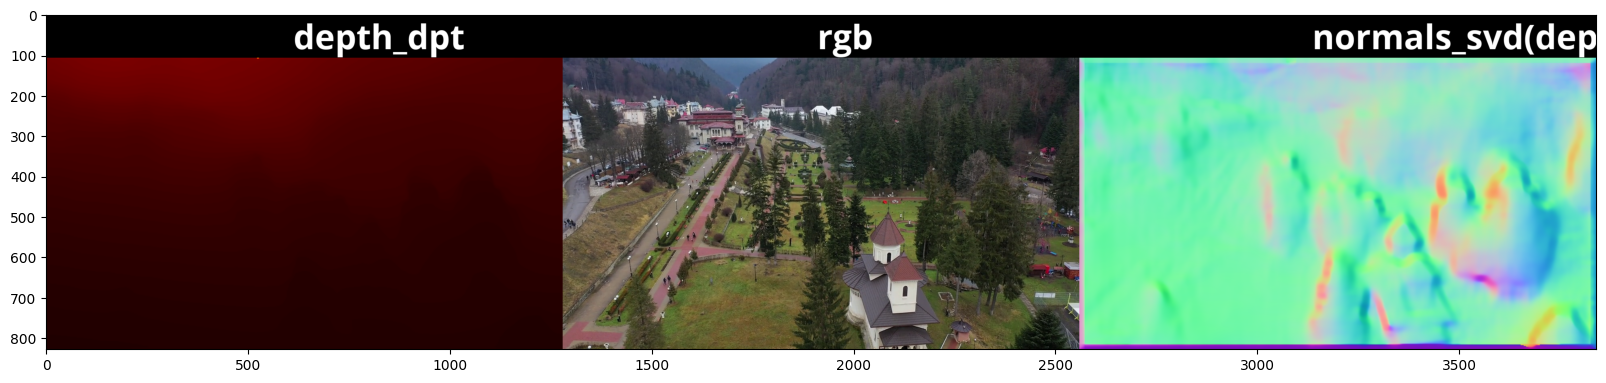

In [5]:
frames = [x.name for x in Path(output_dir / "rgb/png").iterdir()]
start_frame = np.random.permutation(frames)[0]
imgs = [image_read(output_dir / r / "png" / start_frame) for r in vre.representations]
collage = collage_fn(imgs, titles=vre.representations, size_px=70, rows_cols=(1, 3))
image_write(collage, f"collage_{start_frame}")
plt.figure(figsize=(20, 10))
plt.imshow(collage)